<a href="https://colab.research.google.com/github/king-ali/One_Shot_Learning_Siamese_Network_with_Triplet_loss/blob/main/Siamese_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Siamese Network with Triplet loss

Passport checks at airports, automatic turnstiles in office centers, signature verification – all these tasks require face or object recognition

Deep Neural networks are good at every task, but these neural networks rely on more data to perform well. But for some problems like face recognition and signature verification, we can't always rely on more data, to solve this issue we have a new type of one-shot learning neural network architecture called Siamese Networks.

Siamese Neural Network contain two or more identical subnetworks, they have the same configuration with the same parameters and weights




In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install opencv-python
!pip install --upgrade opencv-contrib-python
!pip install rarfile

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 72.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.1 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=8b8a50aca65e7411a71edaeeb68243ecff45f2e008f272d911b4ded4976239ec
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60943 sha256=d598905d52f84e07e9115f395ab92c6fd6c6ad37ccacd416958328abefefa0fb
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c6

# Dataset

We have used 2 categories of snacks dataset.

To download the full dataset:

https://huggingface.co/datasets/Matthijs/snacks


In [2]:
!git clone https://github.com/king-ali/One_Shot_Learning_Siamese_Network_with_Triplet_loss.git

Cloning into 'One_Shot_Learning_Siamese_Network_with_Triplet_loss'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 14 (delta 1), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (14/14), 13.87 MiB | 9.27 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [15]:
import rarfile
%cd /content/One_Shot_Learning_Siamese_Network_with_Triplet_loss
rar = rarfile.RarFile('./data.rar')
rar.extractall()

/content/One_Shot_Learning_Siamese_Network_with_Triplet_loss


# Imports

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm
import sys
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import os
import cv2
import csv
import shutil

# Triplet loss function
Triplet loss will allow our model to map two similar images close and far from dissimilar sample image pairs.

This approach is done by using triplet constituting:

1. Anchor Image — This is a sample image.

2. Positive Image — This is just another variation of the anchor image.

This helps the siamese network model learn the similarities between the two images.

3. Negative Image — This is a different image from the above two similar image pairs.

This helps our model learn dissimilarities with anchor images.

# Preparing Triplet Data


In [18]:
# Making anchor, positive and negative as csv

folder_path_apple = "data/apple"
folder_path_banana = "data/banana"

file_list_apple = os.listdir(folder_path_apple)
file_list_banana = os.listdir(folder_path_banana)

# Apple
half_len = len(file_list_apple) // 2
first_half_apple = file_list_apple[:half_len]
second_half_apple = file_list_apple[half_len:]
negative_apple = file_list_banana[:len(file_list_banana)]

# Banana
half_len = len(file_list_banana) // 2
first_half_banana = file_list_banana[:half_len]
second_half_banana = file_list_banana[half_len:]
negative_banana = file_list_apple[:len(file_list_apple)]

csv_filename = "train.csv"

with open(csv_filename, mode='w', newline='') as csv_file:
    writer = csv.writer(csv_file)

    writer.writerow(["Anchor", "Positive", "Negative"])

    for first, second, third in zip(first_half_apple, second_half_apple, negative_apple):
        writer.writerow([first, second, third])

    for first, second, third in zip(first_half_banana, second_half_banana, negative_banana):
        writer.writerow([first, second, third])


print(f"CSV file '{csv_filename}' has been created.")


CSV file 'train.csv' has been created.


In [19]:
# Moving all files to train folder

source_folders = ["data/apple", "data/banana"]
target_folder = "train"

if not os.path.exists(target_folder):
    os.makedirs(target_folder)

for folder in source_folders:
    files = os.listdir(folder)

    for file in files:
        source_file_path = os.path.join(folder, file)
        target_file_path = os.path.join(target_folder, file)
        shutil.move(source_file_path, target_file_path)

print("All images have been moved to the 'train' folder")


All images have been moved to the 'train' folder


## Making all images to same size

In [21]:
width, height = 320, 320
folder_path = "train"
files = os.listdir(folder_path)

# Iterate through each file
for file in files:
    if file.endswith((".jpg")):
        image_path = os.path.join(folder_path, file)
        img = cv2.imread(image_path)
        resized_img = cv2.resize(img, (width, height))
        cv2.imwrite(image_path, resized_img)

print("All images resized to {}x{}.".format(width, height))

All images resized to 320x320.


# Configurations

In [30]:
DATA_DIR = '/content/One_Shot_Learning_Siamese_Network_with_Triplet_loss/train/'
CSV_FILE = '/content/One_Shot_Learning_Siamese_Network_with_Triplet_loss/train.csv'

BATCH_SIZE = 8
LR = 0.001
EPOCHS = 15
DEVICE = 'cuda'

In [31]:
df = pd.read_csv(CSV_FILE)
df.head()

,Anchor,Positive,Negative
0,46471c20190c370c.jpg,94f7aaa4b60215da.jpg,82c300c750dc2877.jpg
1,1a0c1cd0870da018.jpg,ae54236f37a606f6.jpg,ecfccca39bd642b6.jpg
2,b4cb895b4eb903a4.jpg,6d2453461c9d254e.jpg,d9dbe693bbac5e9f.jpg
3,13adde0a44c48376.jpg,42b649e7990831a1.jpg,27d4b3f273ee822d.jpg
4,b4f2782174484e10.jpg,41e2356b97f775c4.jpg,5451e8d4f723941f.jpg


In [35]:
row = df.iloc[0]

A_img = io.imread(DATA_DIR + row.Anchor)
P_img = io.imread(DATA_DIR + row.Positive)
N_img = io.imread(DATA_DIR + row.Negative)

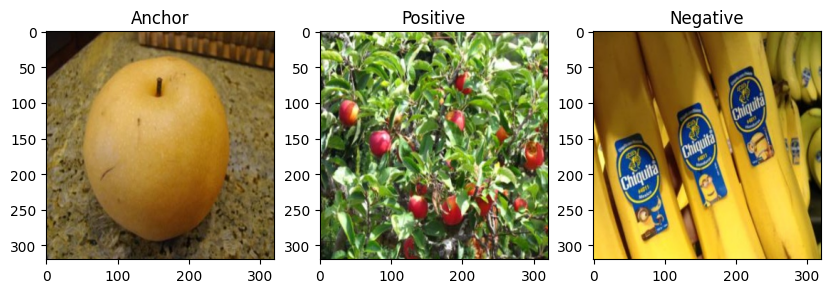

In [36]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (10,5))

ax1.set_title("Anchor")
ax1.imshow(A_img)

ax2.set_title("Positive")
ax2.imshow(P_img)

ax3.set_title("Negative")
ax3.imshow(N_img)

In [37]:
train_df, valid_df = train_test_split(df, test_size = 0.20, random_state = 42)

# Create Anchor Positive Negative

In [38]:
class APN_Dataset(Dataset):
  def __init__(self, df):
    self.df = df
  def __len__(self):
    return len(self.df)
  def __getitem__(self, idx):

    row = self.df.iloc[idx]

    A_img = io.imread(DATA_DIR + row.Anchor)
    P_img = io.imread(DATA_DIR + row.Positive)
    N_img = io.imread(DATA_DIR + row.Negative)

    A_img = torch.from_numpy(A_img).permute(2, 0, 1) / 255.0
    P_img = torch.from_numpy(P_img).permute(2, 0, 1) / 255.0
    N_img = torch.from_numpy(N_img).permute(2, 0, 1) / 255.0

    return A_img, P_img, N_img


In [39]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)

print(f"Size of transet : {len(trainset)}")
print(f"Size of validset : {len(validset)}")

Size of transet : 200
Size of validset : 50


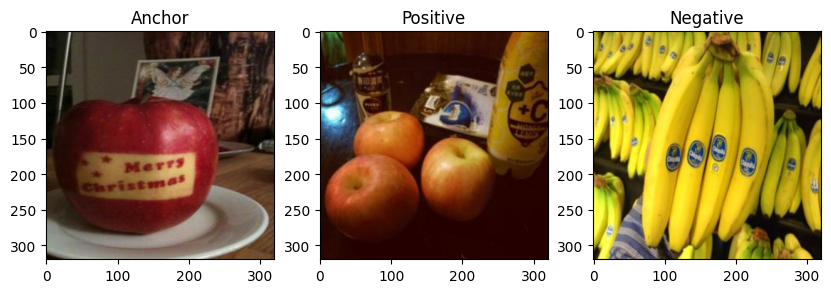

In [40]:
idx = 40
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Loading Dataset into Batches

In [41]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)


In [42]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 25
No. of batches in validloader : 7


In [43]:
for A, P, N in trainloader:
  break

print(f"One image batch shape : {A.shape}")

One image batch shape : torch.Size([8, 3, 320, 320])


# Creating Model
Here we are using EfficientNet pretrained model

In [44]:
class APN_Model(nn.Module):
  def __init__(self, emb_size = 512):
    super(APN_Model, self).__init__()

    self.efficientnet = timm.create_model('efficientnet_b0', pretrained = True)
    self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features= emb_size)

  def forward(self, images):
    embeddings = self.efficientnet(images)

    return embeddings

In [45]:
model = APN_Model()
model.to(DEVICE);

# Creating Train and Eval functions

In [46]:
def train_fn(model, dataloader, optimizer, criterion):

  model.train()
  total_loss = 0.0

  for A, P, N in tqdm(dataloader):

    A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)

    loss = criterion(A_embs, P_embs, N_embs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [47]:
def eval_fn(model, dataloader, criterion):

  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for A, P, N in tqdm(dataloader):

      A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

      A_embs = model(A)
      P_embs = model(P)
      N_embs = model(N)

      loss = criterion(A_embs, P_embs, N_embs)

      total_loss += loss.item()

    return total_loss / len(dataloader)

In [48]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

# Creating Training Loop

In [49]:
best_valid_loss = np.Inf

for i in range(10):

  train_loss = train_fn(model, trainloader, optimizer, criterion)
  valid_loss = eval_fn(model, validloader, criterion)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    best_valid_loss = valid_loss
    print("Saved Weigths Success")
  print(f"EPOCHS : {i+1} train_loss : {train_loss} valid_loss : {valid_loss}")


100%|██████████| 7/7 [00:00<00:00,  8.71it/s]


Saved Weigths Success
EPOCHS : 1 train_loss : 0.8132065439224243 valid_loss : 1.4407477719443185


100%|██████████| 7/7 [00:00<00:00,  9.87it/s]


Saved Weigths Success
EPOCHS : 2 train_loss : 0.6224657487869263 valid_loss : 0.10968800101961408


100%|██████████| 7/7 [00:00<00:00,  9.89it/s]


EPOCHS : 3 train_loss : 0.33929277420043946 valid_loss : 0.8481077551841736


100%|██████████| 7/7 [00:01<00:00,  6.80it/s]


EPOCHS : 4 train_loss : 0.4740982222557068 valid_loss : 1.410560062953404


100%|██████████| 7/7 [00:00<00:00,  9.69it/s]


EPOCHS : 5 train_loss : 0.4643456292152405 valid_loss : 0.5959164244788033


100%|██████████| 7/7 [00:00<00:00, 10.16it/s]


EPOCHS : 6 train_loss : 0.4022182774543762 valid_loss : 1.121838058744158


100%|██████████| 7/7 [00:00<00:00,  8.20it/s]


EPOCHS : 7 train_loss : 0.3984355854988098 valid_loss : 1.5328378762517656


100%|██████████| 7/7 [00:00<00:00,  9.87it/s]


EPOCHS : 8 train_loss : 0.5836482083797455 valid_loss : 0.980424702167511


100%|██████████| 7/7 [00:00<00:00,  9.76it/s]


EPOCHS : 9 train_loss : 0.45348996520042417 valid_loss : 1.7161353485924857


100%|██████████| 7/7 [00:00<00:00,  9.01it/s]

EPOCHS : 10 train_loss : 0.6010689115524293 valid_loss : 1.3343724182673864


# Get Anchor Embeddings

In [50]:
def get_encoding_csv(model, anc_img_names):
  anc_img_names_arr = np.array(anc_img_names)
  encodings = []

  model.eval()
  with torch.no_grad():
    for i in tqdm(anc_img_names_arr):
      A = io.imread(DATA_DIR + i)
      A = torch.from_numpy(A).permute(2, 0, 1) / 255.0
      A = A.to(DEVICE)
      A_enc = model(A.unsqueeze(0))
      encodings.append(A_enc.squeeze().cpu().detach().numpy())

    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    df_enc = pd.concat([anc_img_names, encodings], axis = 1)

  return df_enc

In [51]:
model.load_state_dict(torch.load('best_model.pt'))
df_enc = get_encoding_csv(model, df['Anchor'])

100%|██████████| 250/250 [00:02<00:00, 89.75it/s]


In [52]:
df_enc.to_csv('database.csv', index = False)
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,46471c20190c370c.jpg,0.227209,-0.040228,0.227768,0.058860,-0.094482,-0.693957,-0.132468,0.010886,0.115983,...,0.278470,-0.077056,0.386884,0.380730,0.256116,0.111536,-0.303254,-0.176943,0.287887,-0.408733
1,1a0c1cd0870da018.jpg,-0.255360,0.331236,0.436784,0.012502,0.436997,-0.387705,0.307160,0.081837,-0.079258,...,0.162633,0.351585,0.117903,0.406415,0.098217,0.122076,0.197927,-0.246618,-0.256123,-0.169875
2,b4cb895b4eb903a4.jpg,-0.259009,0.093034,0.102305,0.261780,0.471055,-0.266571,0.014333,0.101202,-0.046861,...,0.292274,0.198751,0.251054,0.463366,0.268874,0.156823,0.221135,-0.473132,-0.031565,-0.024796
3,13adde0a44c48376.jpg,-0.223623,-0.082252,0.365930,0.121827,0.248297,-0.241494,-0.196637,0.101590,-0.230198,...,0.450447,0.095985,0.253873,0.384292,0.200446,0.181201,0.189922,-0.391674,0.033733,-0.077671
4,b4f2782174484e10.jpg,-0.376327,-0.127917,0.134506,-0.141313,0.264190,-0.511655,0.531987,-0.041276,-0.070364,...,0.030066,0.437161,0.075360,0.603631,0.030625,0.191085,0.282681,-0.140914,-0.448128,0.210753


# Inference

In [53]:
def euclidean_dist(img_enc, anc_enc_arr):
  dist = np.sqrt(np.dot(img_enc-anc_enc_arr, (img_enc - anc_enc_arr).T))
  return dist

In [65]:
idx = 8
img_name = df_enc['Anchor'].iloc[idx]
img_path = DATA_DIR + img_name

img = io.imread(img_path)
img = torch.from_numpy(img).permute(2, 0, 1) / 255.0

model.eval()
with torch.no_grad():
  img = img.to(DEVICE)
  img_enc = model(img.unsqueeze(0))
  img_enc = img_enc.detach().cpu().numpy()


In [66]:
anc_enc_arr = df_enc.iloc[:, 1:].to_numpy()
anc_img_names = df_enc['Anchor']


In [67]:
distance = []

for i in range(anc_enc_arr.shape[0]):
  dist = euclidean_dist(img_enc, anc_enc_arr[i : i+1, :])
  distance = np.append(distance, dist)

In [68]:
closest_idx = np.argsort(distance)

## Getting the most similar images

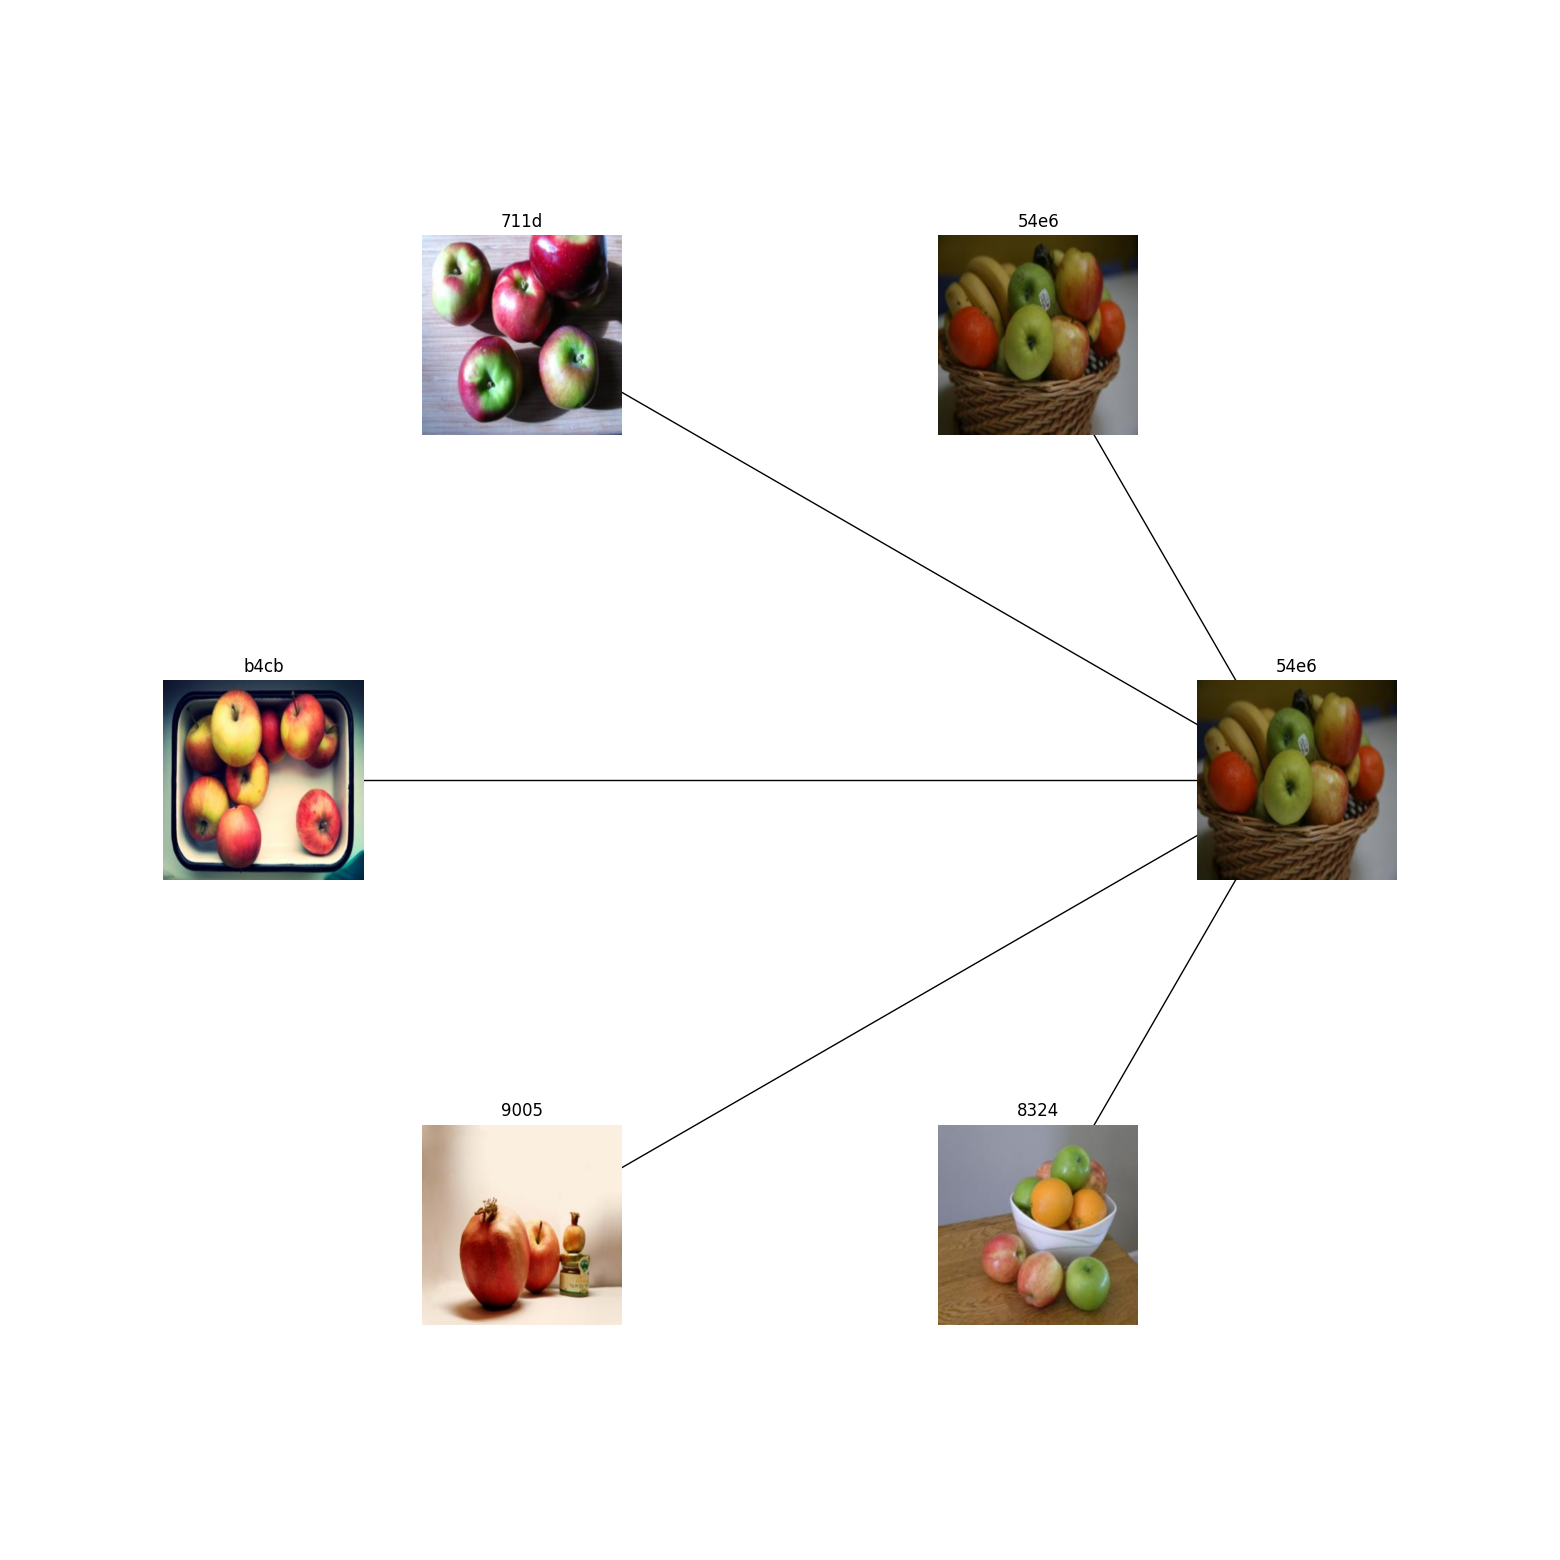

In [69]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names, DATA_DIR, img, img_path, closest_idx, distance, no_of_closest = 5);